In [9]:
import pickle as pkl
import pandas as pd
import numpy as np
# from pymssa import MSSA
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
import umap

In [4]:
data = pd.read_pickle('../data/covid_flow.pkl')

In [3]:
data.columns

Index(['t_point', 'омепразол_stat_control', 'надропарин кальция_stat_control',
       'эзомепразол_stat_control', 'амлодипин_stat_control',
       'амброксол_stat_control', 'домперидон_stat_control',
       'меброфенин_stat_control', 'технеций_stat_control',
       'мометазон_stat_control', 'бисопролол_stat_control',
       'дексаметазон_stat_control', 'гидрохлоротиазид_stat_control',
       'гидроксихлорохин_stat_control', 'рабепразол_stat_control',
       'эноксапарин натрия_stat_control', 'периндоприл_stat_control',
       'ацетилцистеин_stat_control', 'азитромицин_stat_control',
       'валсартан_stat_control', 'метилпреднизолон_stat_control',
       'лоратадин_stat_control', 'хлорохин_stat_control',
       'натрия хлорид_stat_control', 'индапамид_stat_control',
       'преднизолон_stat_control', 'аторвастатин_stat_control',
       'декстран_stat_control', 'лизиноприл_stat_control',
       'лозартан_stat_control', 'Температура_dinam_fact',
       'Лимфоциты#_dinam_fact', 'АСТ_dinam

- `_stat_control` – стационарные признаки, которые описывают контролирующий процесс и не меняются (в covid_flow это бинарные признаки включения 1 или невключения 0 препарата в план лечения)
- `_dinam_control` – динамические признаки, которые описывают контролирующий процесс и меняются (в covid_flow это бинарные признаки включения 1 или невключения 0 процедуры в план лечения)
- `_stat_fact` – стационарные признаки, которые описывают контролируемый процесс и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и все остальное что не меняется)
- `_dinam_fact` – динамические признаки, которые описывают контролирующий процесс и меняются (в covid_flow это признаки описывающие состояние пациентов, например температура, % поражения легких и другое)
- `t_point` – индикатор временного интервала. Вся длительность процесса разбита на равные интервалы времени, t_point – метка интервала.
- `end_epizode` – индикатор конца процесса, 0 – процесс лечения не окончен в данном t_point, 1 – окончен
- `case (index)` – уникальный идентификатор наблюдения (процесса), пример – «GACAk+Q»
- `long_observation_tar` – длинна процесса
- `current_process_duration` – текущая длинна процесса (на момент t_point)
- `outcome_tar` – исход лечения, 1- летальный, 0 – выздоровление

In [92]:
data.dtypes[data.dtypes != 'int64']


t_point                                              object
Температура_dinam_fact                              float64
Лимфоциты#_dinam_fact                               float64
АСТ_dinam_fact                                      float64
ЧСС_dinam_fact                                      float64
ЧДД_dinam_fact                                      float64
Билирубин общий_dinam_fact                          float64
MPV- Средн.объем тромбоцитов_dinam_fact             float64
PCT- Тромбокрит_dinam_fact                          float64
Лимфоциты%_dinam_fact                               float64
Лактатдегидрогеназа_dinam_fact                      float64
PDW- Индекс расп.по объему тр._dinam_fact           float64
process_stages                                       object
admission_date                               datetime64[ns]
dtype: object

In [93]:
data['process_stages'].value_counts()

2      3742
1_1    1247
1_2    1199
Name: process_stages, dtype: int64

In [11]:
data['снижение_сознания_dinam_fact'].value_counts()

0    5823
2     364
1       1
Name: снижение_сознания_dinam_fact, dtype: int64

In [10]:
data['Cтепень тяжести по КТ_dinam_fact'].value_counts()

5    3285
2    1250
1     733
3     696
4     195
0      29
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64

In [94]:
data[data.columns[data.isnull().any()]].isnull().sum()

Температура_dinam_fact                       2459
Лимфоциты#_dinam_fact                         741
АСТ_dinam_fact                               1149
ЧСС_dinam_fact                               1168
ЧДД_dinam_fact                                738
Билирубин общий_dinam_fact                   1973
MPV- Средн.объем тромбоцитов_dinam_fact       762
PCT- Тромбокрит_dinam_fact                    762
Лимфоциты%_dinam_fact                         741
Лактатдегидрогеназа_dinam_fact               1782
PDW- Индекс расп.по объему тр._dinam_fact     764
dtype: int64

In [4]:
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

Температура_dinam_fact                       39.738203
Лимфоциты#_dinam_fact                        11.974790
АСТ_dinam_fact                               18.568197
ЧСС_dinam_fact                               18.875242
ЧДД_dinam_fact                               11.926309
Билирубин общий_dinam_fact                   31.884292
MPV- Средн.объем тромбоцитов_dinam_fact      12.314156
PCT- Тромбокрит_dinam_fact                   12.314156
Лимфоциты%_dinam_fact                        11.974790
Лактатдегидрогеназа_dinam_fact               28.797673
PDW- Индекс расп.по объему тр._dinam_fact    12.346477
dtype: float64

These are dynamic facts, can't just throw them away

In [5]:
df = data.drop(columns=['process_stages', 'admission_date', 't_point'])

In [6]:
import miceforest as mf

# Create kernel 
kernel = mf.ImputationKernel(
  df,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on the dataset
kernel.mice(2)

# Return the completed dataset.
df = kernel.complete_data()

In [5]:
df.isnull().sum().sum()

0

In [44]:
# data.index.value_counts()

In [9]:
data.loc['GACAhЫЭ']

,t_point,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,...,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control,long_observation_tar,outcome_tar,process_stages,current_process_duration,admission_date,end_epizode
case,,,,,,,,,,,,,,,,,,,,,
GACAhЫЭ,t_0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,3,2020-07-14,0
GACAhЫЭ,t_1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,10,2020-07-14,0
GACAhЫЭ,t_2,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,17,2020-07-14,0
GACAhЫЭ,t_3,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,24,2020-07-14,0
GACAhЫЭ,t_4,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,31,2020-07-14,0
GACAhЫЭ,t_5,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,38,2020-07-14,0
GACAhЫЭ,t_6,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,45,2020-07-14,0
GACAhЫЭ,t_7,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,52,2020-07-14,0
GACAhЫЭ,t_8,1,1,1,1,0,0,0,0,0,...,0,0,0,0,190,0,1_2,59,2020-07-14,0


In [46]:
outcome_long = data.groupby(['outcome_tar', 'long_observation_tar']).count()
outcome_long.iloc[:,0]

outcome_tar  long_observation_tar
0            1                        1
             2                        2
             3                       18
             4                       11
             5                       25
                                     ..
1            34                      12
             40                       6
             43                       7
             49                       8
             52                       9
Name: t_point, Length: 89, dtype: int64

## Transition to graph

In [10]:
# make a copy fisrt
new_df = df.copy()

In [27]:
fivestage = df[df['Cтепень тяжести по КТ_dinam_fact'] == 5].index.tolist()
new_df = new_df.drop(fivestage)

In [11]:
# # find  fifth stage
# fivestage = df[(df['Cтепень тяжести по КТ_dinam_fact'] == 5) | (df['Cтепень тяжести по КТ_dinam_fact'] == 2)].index.tolist()
# # choose 50% randomly
# dropIndices = np.random.choice(fivestage, size = int(df.shape[0]*0.5))
# # drop them
# new_df = new_df.drop(dropIndices)

In [8]:
excluded = ['case']
cols_to_keep = [c for c in new_df.columns if c not in excluded]
arr = new_df.loc[:, cols_to_keep].values

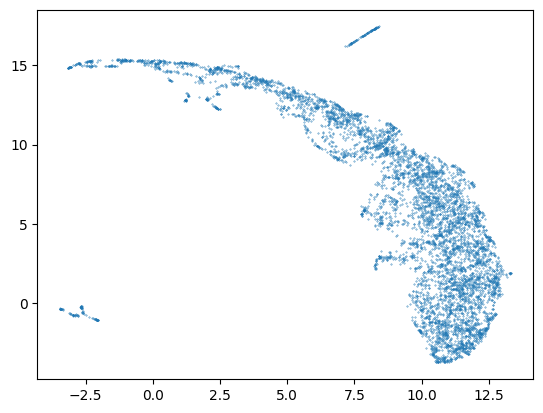

In [11]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(new_df)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],  s=0.1, cmap='Spectral')

In [12]:
SEED = 3
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=6,
    random_state=SEED
)
clusterable_embedding.fit_transform(arr)
embeddings = clusterable_embedding.embedding_


In [38]:
embeddings

array([[-0.8547681 ,  1.3820169 ,  5.4722257 ,  5.223354  ,  5.281586  ,
         1.3598891 ],
       [ 5.452289  , 11.606063  ,  6.9964786 ,  4.5989833 ,  6.4394035 ,
         3.1538684 ],
       [-0.75422883,  1.6289494 ,  5.4508123 ,  5.1926365 ,  5.299938  ,
         1.433139  ],
       ...,
       [ 7.8987236 , 10.111606  ,  5.2029157 ,  5.5275087 ,  6.6299186 ,
         4.7983875 ],
       [10.010674  ,  7.003272  ,  4.0286417 ,  6.6931314 ,  5.9785337 ,
         6.5664124 ],
       [12.766605  ,  1.388978  ,  6.578305  ,  5.221175  ,  4.1701245 ,
         6.4638014 ]], dtype=float32)

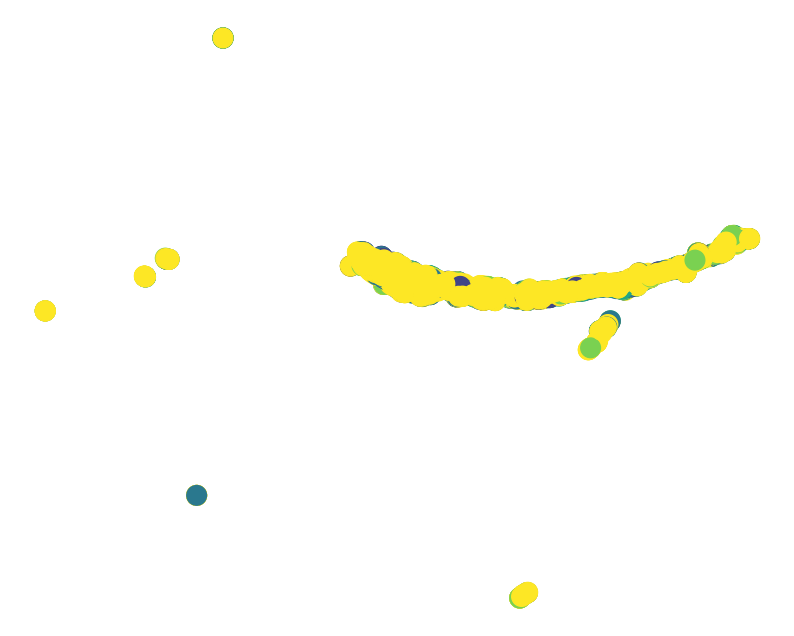

In [13]:
# configure plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

x = embeddings[:, 0]
y = embeddings[:, 1]
plt.scatter(x, y, c=new_df['Cтепень тяжести по КТ_dinam_fact'], s=200)

# append real labels to UMAP points
# for i, label in enumerate(df['Cтепень тяжести по КТ_dinam_fact']):
#     ax.annotate(label, (x[i], y[i]))


In [ ]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(df, km.labels_)
tsne.poof()

Straightforward approach with kmeans

In [35]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 4
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(new_df)
km

KMeans(max_iter=10000, n_clusters=4, n_init=50, random_state=42)

In [36]:
Counter(km.labels_)

Counter({2: 4285, 3: 1538, 0: 307, 1: 58})

In [37]:
new_df['kmeans_cluster'] = km.labels_

In [17]:
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    outcome = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['outcome_tar'].values)
    lenght = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['long_observation_tar'].values)
    age = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['age_stat_fact'].values)
    stage = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['Cтепень тяжести по КТ_dinam_fact'].values)
    print('CLUSTER #'+str(cluster_num))
    print('Lenght of observation:', lenght)
    print('Outcomes:', outcome)
    print('Age:', age)
    print('Severity:', stage)
    print('-'*80)

CLUSTER #0
Lenght of observation: 15.0
Outcomes: 0.0
Age: 62.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #1
Lenght of observation: 12.0
Outcomes: 1.0
Age: 70.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #2
Lenght of observation: 20.0
Outcomes: 1.0
Age: 72.5
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #3
Lenght of observation: 18.0
Outcomes: 0.0
Age: 66.0
Severity: 4.0
--------------------------------------------------------------------------------
CLUSTER #4
Lenght of observation: 17.0
Outcomes: 0.0
Age: 64.0
Severity: 4.0
--------------------------------------------------------------------------------
CLUSTER #5
Lenght of observation: 21.0
Outcomes: 1.0
Age: 81.0
Severity: 5.0
--------------------------------------------------------------------------------


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

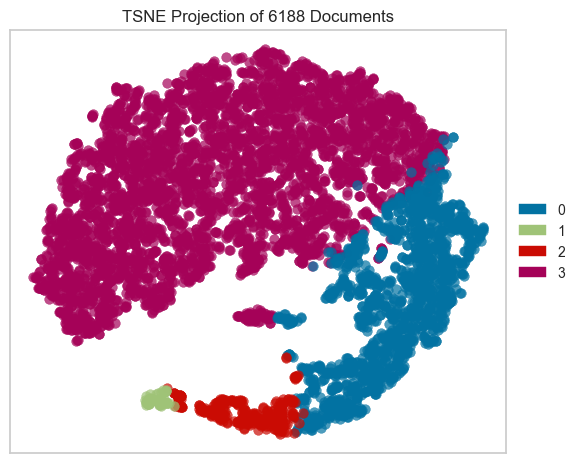

<AxesSubplot:title={'center':'TSNE Projection of 6188 Documents'}>

In [31]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(new_df, km.labels_)
tsne.poof()

In [79]:
new_df = new_df.drop(columns=['kmeans_cluster'])

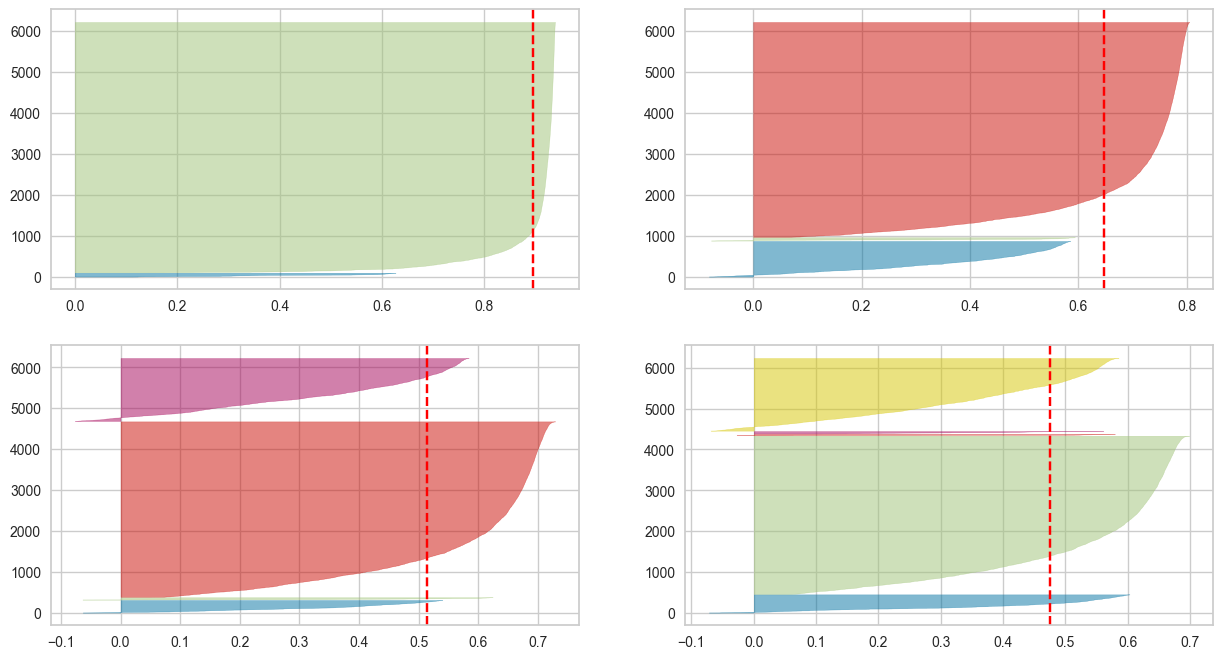

In [56]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=50, max_iter=10000, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

In [32]:

cosine_sim_features = cosine_similarity(new_df)
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)
new_df['kmeans_cluster'] = km.labels_

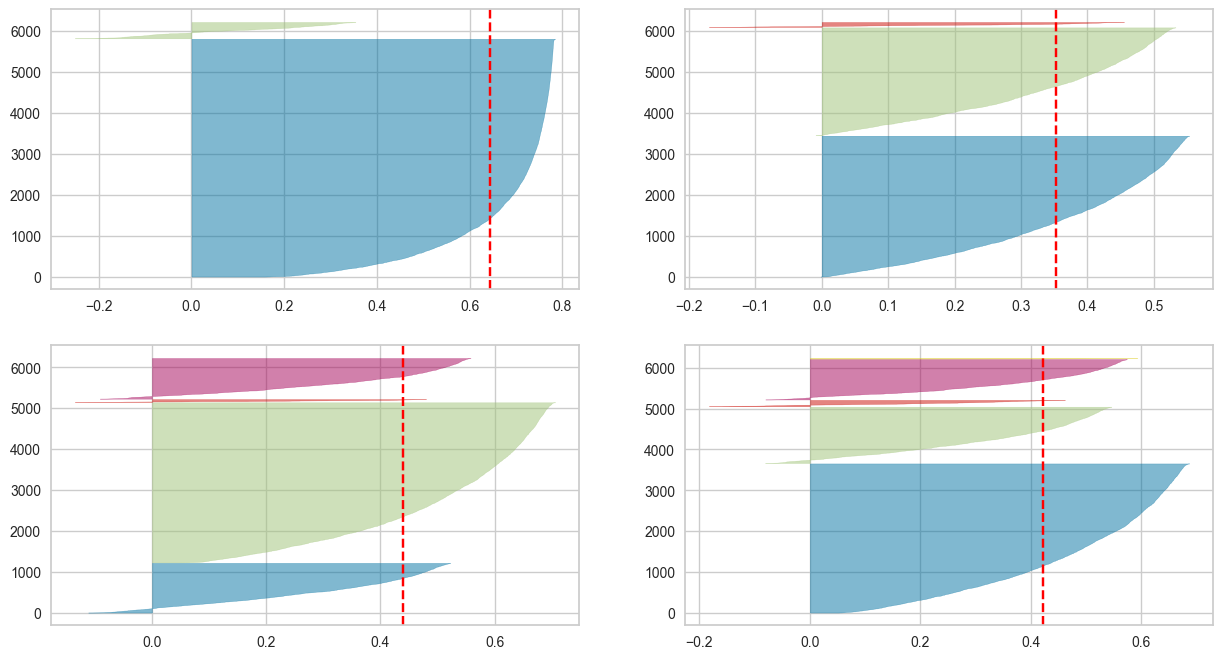

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=50, max_iter=10000, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(cosine_sim_features)

In [21]:
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    outcome = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['outcome_tar'].values)
    lenght = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['long_observation_tar'].values)
    age = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['age_stat_fact'].values)
    stage = np.median(new_df[new_df['kmeans_cluster'] == cluster_num]['Cтепень тяжести по КТ_dinam_fact'].values)
    print('CLUSTER #'+str(cluster_num))
    print('Lenght of observation:', lenght)
    print('Outcomes:', outcome)
    print('Age:', age)
    print('Severity:', stage)
    print('-'*80)

CLUSTER #0
Lenght of observation: 15.0
Outcomes: 0.0
Age: 63.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #1
Lenght of observation: 17.0
Outcomes: 0.0
Age: 62.0
Severity: 4.0
--------------------------------------------------------------------------------
CLUSTER #2
Lenght of observation: 17.0
Outcomes: 0.0
Age: 58.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #3
Lenght of observation: 17.0
Outcomes: 0.0
Age: 63.0
Severity: 4.0
--------------------------------------------------------------------------------
CLUSTER #4
Lenght of observation: 16.0
Outcomes: 0.0
Age: 64.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #5
Lenght of observation: 21.0
Outcomes: 1.0
Age: 68.0
Severity: 5.0
--------------------------------------------------------------------------------


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

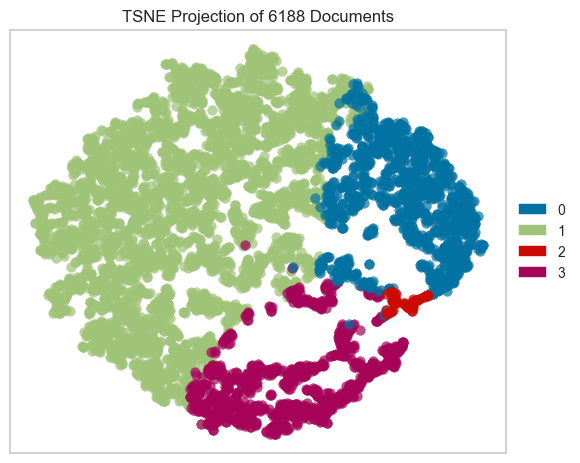

<AxesSubplot:title={'center':'TSNE Projection of 6188 Documents'}>

In [33]:
tsne = TSNEVisualizer()
tsne.fit(cosine_sim_features, km.labels_)
tsne.poof()

In [38]:
silhouette_score(new_df.drop(columns = 'kmeans_cluster'), new_df.kmeans_cluster)

0.5142103976891635

In [103]:
km = KMeans(n_clusters=5, n_init=50, max_iter=10000, random_state=42).fit(cosine_sim_features)

silhouette_score(cosine_sim_features, km.labels_)


0.42272859093014287

# Clustering with only controlled features


In [43]:
chosen_columns = ['Температура_dinam_fact', 'Лимфоциты#_dinam_fact', 'АСТ_dinam_fact', 'ЧСС_dinam_fact',
       'ЧДД_dinam_fact', 'Билирубин общий_dinam_fact', 'MPV- Средн.объем тромбоцитов_dinam_fact', 'PCT- Тромбокрит_dinam_fact',
       'Лимфоциты%_dinam_fact', 'снижение_сознания_dinam_fact', 'Cтепень тяжести по КТ_dinam_fact', 'Лактатдегидрогеназа_dinam_fact',
       'PDW- Индекс расп.по объему тр._dinam_fact', 'age_stat_fact', 'long_observation_tar',
       'outcome_tar', 'current_process_duration']
df_fact = df[chosen_columns]

In [44]:
# df_controlled = df.loc[:, df.columns.str.endswith('fact')]

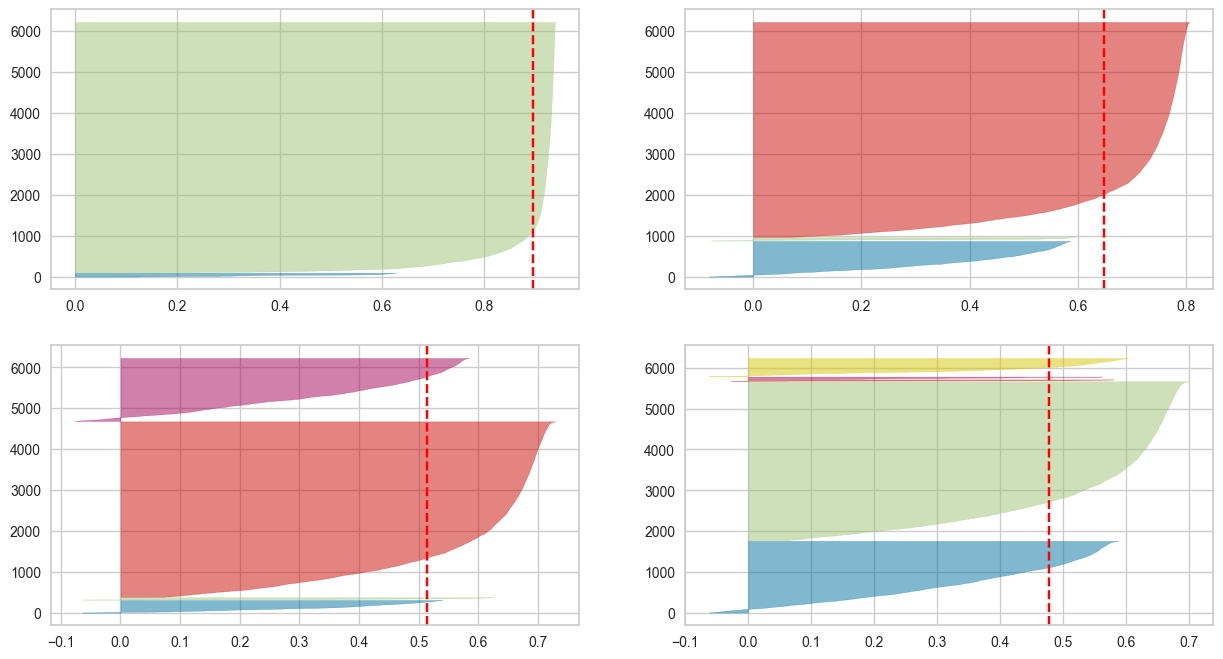

In [42]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=50, max_iter=10000, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_fact)

In [47]:
CLUSTER_NUM = 4
km = KMeans(n_clusters=CLUSTER_NUM, max_iter=10000, n_init=50, random_state=42).fit(df_fact)
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]
print(Counter(km.labels_))
# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(CLUSTER_NUM):
    outcome = np.median(df_fact[km.labels_ == cluster_num]['outcome_tar'].values)
    lenght = np.median(df_fact[km.labels_ == cluster_num]['long_observation_tar'].values)
    age = np.median(df_fact[km.labels_ == cluster_num]['age_stat_fact'].values)
    stage = np.median(df_fact[new_df['kmeans_cluster'] == cluster_num]['Cтепень тяжести по КТ_dinam_fact'].values)
    print('CLUSTER #'+str(cluster_num))
    print('Lenght of observation:', lenght)
    print('Outcomes:', outcome)
    print('Age:', age)
    print('Severity:', stage)
    print('-'*80)
print(silhouette_score(df_fact, km.labels_))

Counter({2: 4285, 3: 1538, 0: 307, 1: 58})
CLUSTER #0
Lenght of observation: 18.0
Outcomes: 0.0
Age: 66.0
Severity: 4.0
--------------------------------------------------------------------------------
CLUSTER #1
Lenght of observation: 14.0
Outcomes: 1.0
Age: 72.5
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #2
Lenght of observation: 15.0
Outcomes: 0.0
Age: 63.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #3
Lenght of observation: 18.0
Outcomes: 0.0
Age: 64.0
Severity: 4.0
--------------------------------------------------------------------------------
0.5145680351945415


In [48]:
CLUSTER_NUM = 5
km = KMeans(n_clusters=CLUSTER_NUM, max_iter=10000, n_init=50, random_state=42).fit(df_fact)
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]
print(Counter(km.labels_))
# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(CLUSTER_NUM):
    outcome = np.median(df_fact[km.labels_ == cluster_num]['outcome_tar'].values)
    lenght = np.median(df_fact[km.labels_ == cluster_num]['long_observation_tar'].values)
    age = np.median(df_fact[km.labels_ == cluster_num]['age_stat_fact'].values)
    stage = np.median(df_fact[km.labels_ == cluster_num]['Cтепень тяжести по КТ_dinam_fact'].values)
    print('CLUSTER #'+str(cluster_num))
    print('Lenght of observation:', lenght)
    print('Outcomes:', outcome)
    print('Age:', age)
    print('Severity:', stage)
    print('-'*80)
print(silhouette_score(df_fact, km.labels_))

Counter({1: 3896, 0: 1754, 4: 445, 3: 59, 2: 34})
CLUSTER #0
Lenght of observation: 18.0
Outcomes: 0.0
Age: 64.0
Severity: 4.0
--------------------------------------------------------------------------------
CLUSTER #1
Lenght of observation: 15.0
Outcomes: 0.0
Age: 62.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #2
Lenght of observation: 11.5
Outcomes: 1.0
Age: 66.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #3
Lenght of observation: 20.0
Outcomes: 1.0
Age: 75.0
Severity: 5.0
--------------------------------------------------------------------------------
CLUSTER #4
Lenght of observation: 18.0
Outcomes: 0.0
Age: 66.0
Severity: 4.0
--------------------------------------------------------------------------------
0.47720814848841797


In [49]:
CLUSTER_NUM = 4
cosine_sim_features = cosine_similarity(df_fact)
km = KMeans(n_clusters=CLUSTER_NUM, max_iter=10000, n_init=50, random_state=42).fit(cosine_sim_features)
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]
print(Counter(km.labels_))
# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(CLUSTER_NUM):
    outcome = np.median(df_fact[km.labels_ == cluster_num]['outcome_tar'].values)
    lenght = np.median(df_fact[km.labels_ == cluster_num]['long_observation_tar'].values)
    age = np.median(df_fact[km.labels_ == cluster_num]['age_stat_fact'].values)
    print('CLUSTER #'+str(cluster_num))
    print('Lenght of observation:', lenght)
    print('Outcomes:', outcome)
    print('Age:', age)
    print('-'*80)
print(silhouette_score(df_fact, km.labels_))

Counter({2: 3911, 1: 1215, 0: 994, 3: 68})
CLUSTER #0
Lenght of observation: 17.0
Outcomes: 0.0
Age: 62.0
--------------------------------------------------------------------------------
CLUSTER #1
Lenght of observation: 15.0
Outcomes: 0.0
Age: 63.0
--------------------------------------------------------------------------------
CLUSTER #2
Lenght of observation: 16.0
Outcomes: 0.0
Age: 63.0
--------------------------------------------------------------------------------
CLUSTER #3
Lenght of observation: 21.0
Outcomes: 0.0
Age: 58.0
--------------------------------------------------------------------------------
0.18798491105312445


## Further there are just expirements (not ready to share these methods)

In [109]:
from pgmpy.estimators import K2Score
import bamt.Networks as Nets
import bamt.Preprocessors as pp
from bamt.utils import GraphUtils as gru

encoder = LabelEncoder()
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('discretizer', discretizer)])
bn_data, est = p.apply(df.iloc[0:15,:])


nodes_type_mixed = gru.nodes_types(bn_data)

info = p.info


In [110]:
bn = Nets.DiscreteBN()
bn.add_nodes(descriptor=info)

bn.add_edges(data=bn_data, optimizer='HC', scoring_function=('K2', K2Score))
bn.get_info()

2022-11-08 01:25:27,071 | ERROR    | Networks.py-add_nodes-0080 | Discrete BN does not support continuous data


KeyError: 'омепразол_stat_control'

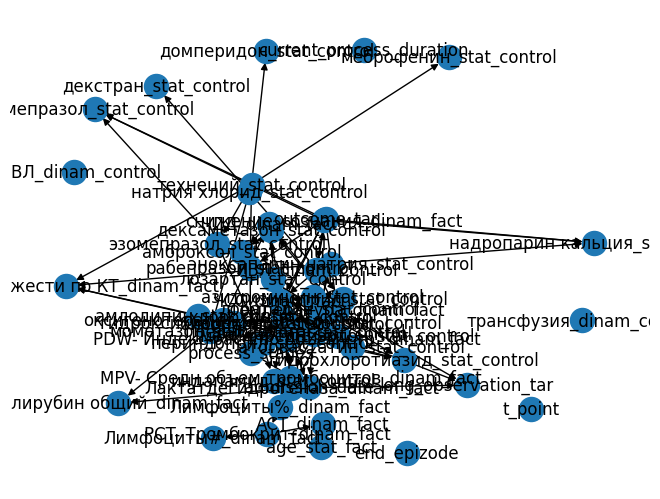

In [24]:
from pyvis.network import Network
import random

G = nx.DiGraph()
nodes = [node.name for node in bn.nodes]
G.add_nodes_from(nodes)
G.add_edges_from(bn.edges)

network = Network(notebook=True, directed=nx.is_directed(G),
                    layout='hierarchical')

nodes_sorted = np.array(
    list(nx.topological_generations(G)), dtype=object)

# Qualitative class of colormaps
q_classes = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20',
                'tab20b', 'tab20c']

hex_colors = []
for cls in q_classes:
    rgb_colors = plt.get_cmap(cls).colors
    hex_colors.extend(
        [matplotlib.colors.rgb2hex(rgb_color) for rgb_color in rgb_colors])

hex_colors = np.array(hex_colors)

# Number_of_colors in matplotlib in Qualitative class = 144

class_number = len(
    set([node.type for node in bn.nodes])
)
hex_colors_indexes = [random.randint(
    0, len(hex_colors) - 1) for _ in range(class_number)]
hex_colors_picked = hex_colors[hex_colors_indexes]
class2color = {cls: color for cls, color in zip(
    set([node.type for node in bn.nodes]), hex_colors_picked)}
name2class = {node.name: node.type for node in bn.nodes}

for level in range(len(nodes_sorted)):
    for node_i in range(len(nodes_sorted[level])):
        name = nodes_sorted[level][node_i]
        cls = name2class[name]
        color = class2color[cls]
        network.add_node(name, label=name, color=color, size=45, level=level, font={'size': 36},
                            title=f'Узел байесовской сети {name} ({cls})')

for edge in G.edges:
    network.add_edge(edge[0], edge[1])

network.hrepulsion(node_distance=300, central_gravity=0.5)

# network.show('vis.html')
nx.draw(G, with_labels = True)

In [36]:
from scipy import sparse
import torch
def make_graph(scores, threshold=True, k_closest=False, k=3):
    print('==> Getting edges')
    no_pts = len(scores)
    if k_closest:
        k_ = k
    else:
        k_ = 1 # ensure there is at least one edge per node in the threshold graph
    edges = sparse.lil_matrix((no_pts, no_pts), dtype=np.uint8)
    scores.fill_diagonal_(0)  # get rid of self connection scores
    for patient in range(no_pts):
        k_highest = torch.sort(scores[patient].flatten()).indices[-k_:]
        for i in k_highest:
            edges[patient, i] = 1
    del scores
    edges = edges + edges.transpose()  # make it symmetric again
    # do upper triangle again and then save
    edges = sparse.tril(edges, k=-1)
    if threshold:
        scores_lower = torch.tril(scores, diagonal=-1)
        del scores
        desired_no_edges = k * no_pts
        threshold_value = torch.sort(scores_lower.flatten()).values[-desired_no_edges]
        #for batch in batch(no_pts, n=10):
        for batch in torch.split(scores_lower, 100, dim=0):
            batch[batch < threshold_value] = 0
        edges = edges + sparse.lil_matrix(scores_lower)
        del scores_lower
    v, u, _ = sparse.find(edges)
    return u, v, k

d:\research\research-work\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph construction by clustering points of system trajectory in the state space

In [10]:
'''Удаление тренда как линейной аппроксимациипервой компоненты MSSA
возвращает ряд без тренда и коэффициенты тренда Ax+b отдельно'''
def RemTrend(x):
    mssa = MSSA(n_components=8, #'variance_threshold',
            #variance_explained_threshold=0.98,#,'svht',
            window_size=None,
            verbose=True)
    mssa.fit(x)
    tr = np.zeros(x.shape[0])
    tr[:] = np.nan
    tr = mssa.components_[0, :, :]#.sum(axis=1)
    s=tr[:,0]
    x=np.arange(len(s))
    A = np.vstack([x, np.ones(len(s))]).T
    m, c = np.linalg.lstsq(A, s, rcond=None)[0]
    z=y-m*x-c
    return z, m, c

In [11]:
'''Линейное укладывание в диапазон [0,1], возвращает коэффициенты для восстановления (max(X))!=0'''
def Norm01(x):
    mi=np.nanmin(x)
    ma=np.nanmax(np.array(x)-mi)
    x_n=(np.array(x)-mi)/ma
    return x_n, mi, ma

In [12]:
'''Создание графа из ряда'''
def MakeGraph(self, mindist=.01, method='hierarchy', k=25):
    depth=self.demb*2+1
    self.traject=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
    self.traject['step']=np.arange(len(self.row)-depth)
    for i in range(len(self.row)-depth):
        self.traject.loc[i, self.traject.columns[1:]]=self.row[i:i+depth]
    if method=='hierarchy':
        '''матрица связей для кластеризации'''
        link = linkage(self.traject[self.traject.columns[1:]], 'ward', 'euclidean')
        '''оптимальное расстояние для кластеризации'''
        dist = link[:, 2]
        dist_rev = dist[::-1]
        i=np.where(np.abs(dist_rev[:-5]-dist_rev[5:])<(max(dist_rev)*mindist))[0][0]
        d=dist_rev[i]
        '''кластеризация'''
        self.traject['cluster']=fcluster(link, d, criterion='distance')
    else:
        model = KMeans(n_clusters=k)
        zz=self.traject[self.traject.columns[1:]]
        model.fit(zz)
        '''кластеризация'''
        self.traject['cluster']=model.labels_
    self.traject['cluster']=[list(self.traject['cluster'].drop_duplicates().values).index(i)+1
                                for i in self.traject['cluster']]
    '''Граф'''
    nod=self.traject['cluster'].values
    self.G=nx.DiGraph()
    self.G.add_nodes_from(self.traject['cluster'].unique())
    r=[(nod[j], nod[j+1]) for j in range(len(self.traject)-1)]
    c=[r.count(i) for i in r]
    self.G.add_weighted_edges_from([(nod[j], nod[j+1],c[j]) for j in range(len(self.traject)-1)])
    self.n_nodes=self.G.number_of_nodes()
    return self.G

In [13]:
z, a,b = RemTrend(data.sample(frac=0.25, random_state=1))
z=Norm01(z)[0]
G=MakeGraph(z, mindist=.01, method='hierarchy', k=25)#'KMeans'Norm01(z)[0]

Constructing trajectory matrix


In [33]:
sample = labeled_data.sample(frac=0.10)
N = sample.shape[0]
P = sample.shape[1]
L = (N // 2)
K = N - L + 1

In [34]:
from scipy.linalg import hankel

def ts_vector_to_trajectory_matrix(timeseries, L, K):
    hankelized = hankel(timeseries, np.zeros(L)).T
    hankelized = hankelized[:, :K]
    return hankelized


def ts_matrix_to_trajectory_matrix(timeseries, L, K):
    '''Forulation for V-MSSA (vertical stack)
    https://www.researchgate.net/publication/263870252_Multivariate_singular_spectrum_analysis_A_general_view_and_new_vector_forecasting_approach
    '''
    N, P = timeseries.shape

    trajectory_matrix = [
        ts_vector_to_trajectory_matrix(timeseries.iloc[:, p], L, K)
        for p in range(P)
    ]

    trajectory_matrix = np.concatenate(trajectory_matrix, axis=0)
    return trajectory_matrix

In [35]:
traject = ts_matrix_to_trajectory_matrix(sample, L, K)

In [37]:
'''матрица связей для кластеризации'''
link = linkage(traject, 'ward', 'euclidean')
'''оптимальное расстояние для кластеризации'''
dist = link[:, 2]
dist_rev = dist[::-1]
i=np.where(np.abs(dist_rev[:-5]-dist_rev[5:])<(max(dist_rev)*.01))[0][0]
d=dist_rev[i]
'''кластеризация'''
cluster_array=fcluster(link, d, criterion='distance')

In [42]:
cluster_array=[list(pd.Series(cluster_array).drop_duplicates().values).index(i)+1
                                 for i in cluster_array]
'''Граф'''
nod=cluster_array
G=nx.DiGraph()
G.add_nodes_from(pd.Series(cluster_array).unique())
r=[(nod[j], nod[j+1]) for j in range(len(traject)-1)]
c=[r.count(i) for i in r]
G.add_weighted_edges_from([(nod[j], nod[j+1],c[j]) for j in range(len(traject)-1)])
n_nodes=G.number_of_nodes()

C:\Users\sophi\AppData\Local\Temp\ipykernel_6864\1158145033.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


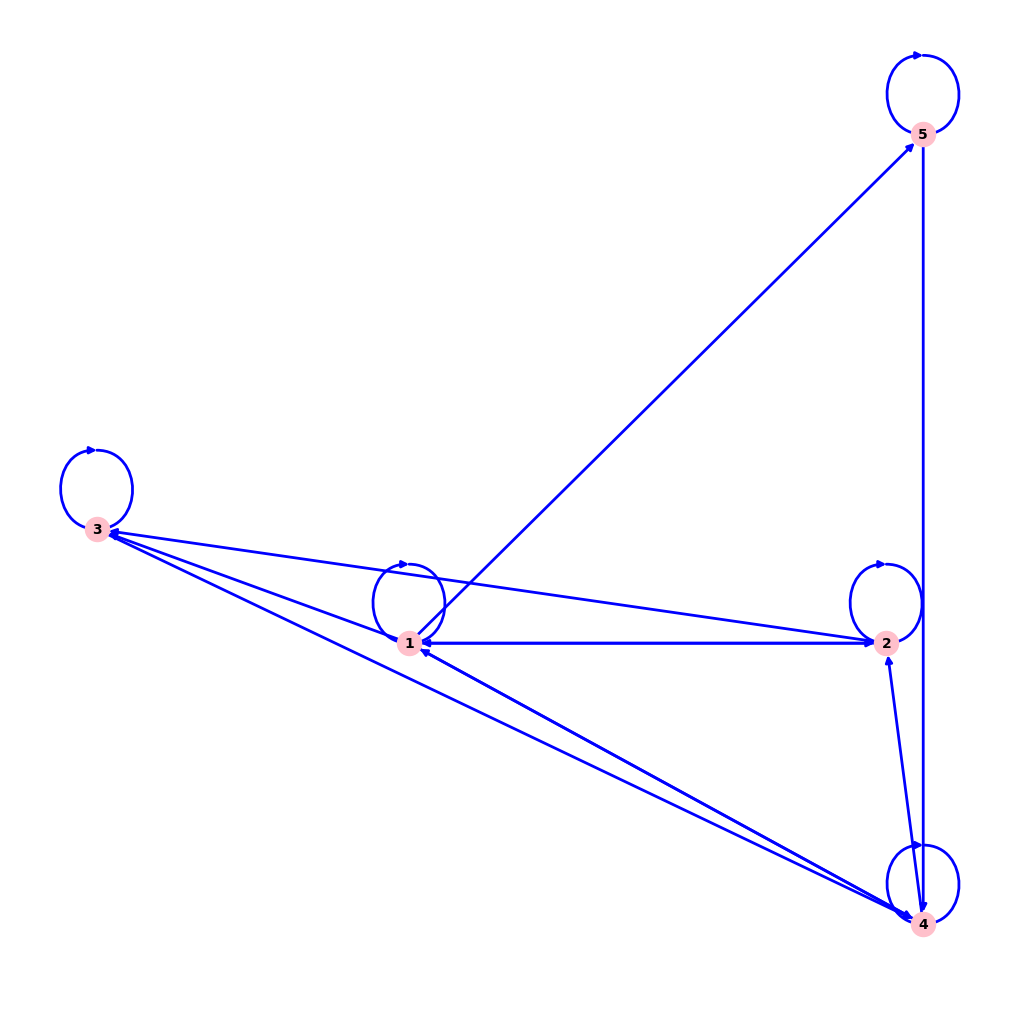

In [46]:
matplotlib.style.use('fast')
fig=plt.figure(figsize=(10, 10))
lnd=n_nodes+1
nnd=lnd//3
nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
nx.draw(G, pos=nx.shell_layout(G, nlist=nlist),
                with_labels=True,
                node_color='pink', font_weight='bold',font_size=10,
                edge_color='b',node_size=300, width=2 )
#nx.spectral_layout(G), random, circular
fig.tight_layout()
plt.show()